In [11]:
from nidaqmx.constants import (TerminalConfiguration)
import pandas as pd
from pymodbus.client.sync import ModbusSerialClient as mbc
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx
from scipy import stats
import csv
import time as ti
import serial as ser
from matplotlib.axes import Axes as ax
%matplotlib notebook

In [107]:
with nidaqmx.Task() as task:
    ai_channel = task.ai_channels.add_ai_voltage_chan("cDAQ1Mod1/ai1",terminal_config = TerminalConfiguration.BAL_DIFF)
    task.start()
    print(task.read())
    task.stop()
    ai_channel = task.ai_channels.add_ai_voltage_chan("cDAQ1Mod1/ai1",terminal_config = TerminalConfiguration.BAL_DIFF)

0.003147996140392716


DaqError: Specified channel cannot be added to the task, because a channel with the same name is already in the task.
Channel Name: cDAQ1Mod1/ai1

Task Name: _unnamedTask<30>

Status Code: -200489

In [4]:
import nidaqmx.system
system = nidaqmx.system.System.local()
for device in system.devices:
    print(device)

Device(name=cDAQ1)
Device(name=cDAQ1Mod1)


# Continous data acqisition of 3 + voltage ports
This program will record voltage data 1000 times a second from each port on DAQ specified. It then saves it to 3 different files and plots the data.

Press ENTER/RETURN to stop acquisition and coil drivers.


OPM acquisition ended.

Acquisition duration: 0:00:03.965125.
Acquired samples: 3800.


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x2edc2349240>


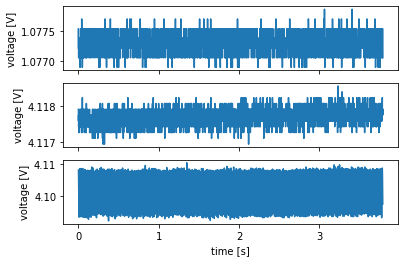

In [140]:
"""
Analog data acquisition for QuSpin's OPMs via National Instruments' cDAQ unit
The following assumes:
"""

# Imports
import matplotlib.pyplot as plt
import numpy as np

import nidaqmx
from nidaqmx.stream_readers import AnalogMultiChannelReader
from nidaqmx import constants
from nidaqmx.constants import (TerminalConfiguration)
# from nidaqmx import stream_readers  # not needed in this script
# from nidaqmx import stream_writers  # not needed in this script

import threading
import pickle
from datetime import datetime
import scipy.io


# Parameters
sampling_freq_in = 1000  # in Hz
buffer_in_size = 100
bufsize_callback = buffer_in_size
buffer_in_size_cfg = round(buffer_in_size * 1)  # clock configuration
chans_in = 3  # set to number of active OPMs (x2 if By and Bz are used, but that is not recommended)
refresh_rate_plot = 10  # in Hz
my_filename = 'test_3_opms'  # with full path if target folder different from current folder (do not leave trailing /)



# Initialize data placeholders
buffer_in = np.zeros((chans_in, buffer_in_size))
data = np.zeros((chans_in, 1))  # will contain a first column with zeros but that's fine


#function decides wheather or not to continue pulling data based on user input
def ask_user():
    global running
    input("Press ENTER/RETURN to stop acquisition and coil drivers.")
    running = False

#sets paramaters for data acquisition
def cfg_read_task(acquisition):  # uses above parameters
    acquisition.ai_channels.add_ai_voltage_chan("cDAQ1Mod1/ai1:3", terminal_config = TerminalConfiguration.BAL_DIFF)  # has to match with chans_in
    acquisition.timing.cfg_samp_clk_timing(rate=sampling_freq_in, sample_mode=constants.AcquisitionType.CONTINUOUS,
                                           samps_per_chan=buffer_in_size_cfg)

#continuos method of pulling data
def reading_task_callback(task_idx, event_type, num_samples, callback_data):  # bufsize_callback is passed to num_samples
    global data
    global buffer_in

    if running:
        # It may be wiser to read slightly more than num_samples here, to make sure one does not miss any sample,
        # see: https://documentation.help/NI-DAQmx-Key-Concepts/contCAcqGen.html
        buffer_in = np.zeros((chans_in, num_samples))  # double definition ???
        stream_in.read_many_sample(buffer_in, num_samples, timeout=constants.WAIT_INFINITELY)

        data = np.append(data, buffer_in, axis=1)  # appends buffered data to total variable data

    return 0  # Absolutely needed for this callback to be well defined (see nidaqmx doc).


# Configure and setup the tasks
task_in = nidaqmx.Task()
cfg_read_task(task_in)
stream_in = AnalogMultiChannelReader(task_in.in_stream)
task_in.register_every_n_samples_acquired_into_buffer_event(bufsize_callback, reading_task_callback)


# Start threading to prompt user to stop
thread_user = threading.Thread(target=ask_user)
thread_user.start()


# Main loop
running = True
time_start = datetime.now()
task_in.start()


# Plot a visual feedback for the user's mental health
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='all', sharey='none')
while running:  # make this adapt to number of channels automatically
    xticks = np.arange(0, data[0, -sampling_freq_in * 5:].size, sampling_freq_in)
    xticklabels = np.arange(0, xticks.size, 1)
    
# Close task to clear connection once done
task_in.close()
duration = datetime.now() - time_start


# Final save data and metadata ... first in python reloadable format:
filename = my_filename
with open(filename, 'wb') as f:
    pickle.dump(data, f)
'''
Load this variable back with:
with open(name, 'rb') as f:
    data_reloaded = pickle.load(f)
'''
# Human-readable text file:
extension = '.txt'
np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # turn off summarization, line-wrapping
with open(filename + extension, 'w') as f:
    f.write(np.array2string(data.T, separator=', '))  # improve precision here!
# Now in matlab:
extension = '.mat'
scipy.io.savemat(filename + extension, {'data':data})


# Some messages at the end
num_samples_acquired = data[0,:].size
print("\n")
print("DAQ acquisition ended.\n")
print("Acquisition duration: {}.".format(duration))
print("Acquired samples: {}.".format(num_samples_acquired - 1))


# Final plot of whole time course the acquisition
plt.close('all')
f_tot, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='all', sharey='none')
ax1.plot(data[0, 10:].T)  # note the exclusion of the first 10 iterations (automatically zoomed in plot)
ax2.plot(data[1, 10:].T)
ax3.plot(data[2, 10:].T)
# Label formatting ...
ax3.set_xlabel('time [s]')
ax1.set_ylabel('voltage [V]')
ax2.set_ylabel('voltage [V]')
ax3.set_ylabel('voltage [V]')
xticks = np.arange(0, data[0, :].size, sampling_freq_in)
xticklabels = np.arange(0, xticks.size, 1)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticklabels)
plt.show()

# Plan for code of final design

Start communication lines to motor board and DAQ
Home Motor
Motor moves from home position all the way from one end to the other
As motor moves record mesurment from DAQ every X seconds
plot data as heat map

In [3]:
#------------------------Motor API for Grbl Bard via USB serial commands-------------------#
#required imports-->
import serial as ser
#------------------------------------------------------------------------------------------#
#$0=10
#$1=25
#$2=1
#$3=1
#$4=0
#$5=1
#$6=0
#$10=1
#$11=0.010
#$12=0.002
#$13=0
#$20=0
#$21=1
#$22=1
#$23=1
#$24=25.000
#$25=500.000
#$26=250
#$27=3.000
#$30=1000
#$31=0
#$32=0
#$100=200.000
#$101=250.000
#$102=250.000
#$110=500.000
#$111=500.000
#$112=500.000
#$120=10.000
#$121=10.000
#$122=10.000
#$130=200.000
#$131=200.000
#$132=200.000
class Motor:
    #function initializes grbl
    def __init__(self,address):
        try:
            #creat variable with communication line to motor
            #.Serial(port_address,board_rate) -----> baud rate is 115200 for Grbl firmware 1.1
            self.rob = ser.Serial(str(address),115200)
            #send command that tells grbl we are starting a serial communication line
            self.rob.write('\r\n\r\n'.encode('utf'))
            ti.sleep(2)   # Wait for grbl to initialize
            #read back grbl response
            back_com = self.rob.read_all().decode('utf-8')
            #print response
            print(back_com)
            #check if response is correct
            if(back_com[:6] != ''):
                print('')
            else:
                print('WARNING : Grbl board did not communicate back properly')
        #print exception is connection does not work
        except Exception as e:
            print(e)
            print('Failed to connect to motor driver board')
    #function will close Grbl
    def close(self):
        try:
            self.rob.close()
        except Exception as e:
            print(e)
            print('Serial communication line failed to close')
    #function will move bar to the position specifies in mm from home position
    #They will not 
    def move_pos(self,position1):
        try:
            #creat grbl command with specified coardinate
            com = 'G0 X' + str(position1) +' Y' + str(position1) +'\r\n'
            print(com)
            #write command to grbl board
            self.rob.write(com.encode('utf'))
            #time.sleep(2)   # Wait for grbl to initialize
            #read back grbl response
            #back_com = self.rob.read_all().decode('utf-8')
            #print(back_com)
        except Exception as e:
            print(e)
            print('Motor failed to move to given position.')
            user = input('Try again?:Y/N')
            if((str(user) == 'Y') | (str(user) == 'y')):
                try:
                    self.rob.write(com.encode('utf'))
                    ti.sleep(2)   # Wait for grbl to initialize
                    #read back grbl response
                    back_com = self.rob.read_all().decode('utf-8')
                    print(back_com)
                except Exception as e:
                    print(e)
                    print('Motor failed to move to given position.')
            else:
                print('possible solutions: home the device with home(), power cycle device')
            
    #function homes the light sensor bar
    def home(self):
        try:
            # HOME
            self.rob.write('$h\r\n'.encode('utf'))  # Tell grbl to home
            ti.sleep(1)   # Wait for grbl
#             self.rob.write('g92 x0 y0 z0\r\n'.encode('utf-8')) # reset g coordinates to 0
#             back_com = self.rob.read_all().decode('utf-8')
            print(back_com)
        except Exception as e:
            print(e)
            print('failed to home device. Homing possibly turned off. $21 and $22 must == 1')
    #function writes to grbl a serial command. Usefull for trouble shooting and settup
    def write(self,to_write):
        try:
            com = str(to_write) + '\r\n'
            self.rob.write(com.encode('utf'))  # Tell grbl to home
            #time.sleep()   # Wait for grbl
            print(self.rob.read_all().decode('utf-8'))
        except Exception as e:
            print(e)
            print('command send failed. Ensure command is either acceptable G code and machine is turned')
    #flush input
    def flushInput(self):
        try:
            self.rob.flushInput()
        except Exception as e:
            print(e)
    #read untill
    def read_until(self,temp):
        try: 
            temp = self.rob.read_until().decode('utf-8')
            return temp
        except Exception as e:
            print(e)

# Below I will start to build an error handled API for the DAQmx library communication 

In [4]:
#------------------------DAQ API for NI DAQ 9205 via USB DAQmx python library-------------------#
#required imports-->
import nidaqmx
from nidaqmx.stream_readers import AnalogMultiChannelReader
from nidaqmx import constants
from nidaqmx.constants import (TerminalConfiguration)
import pandas as pd
#----------------------------------------------------------------------------------------------#

class DAQ:
#---------initial set up for DAQ----------------#
     def __init__(self):
        try:
            self.task = nidaqmx.Task()
        except Exception as e:
            print(e)
            print('Failed to connect to NI DAQ.')
#--------------start task-----------------------#
     def start(self):
        try: 
            self.task.start()
        except Exception as e:
            print(e)
            print('Task failed to start correctly. Ensure task has already been set up.')
#--------------stop task-------------------------#
     def stop(self):
        try: 
            self.task.stop()
        except Exception as e:
            print(e)
            print('Task failed to stop correctly. Ensure task has already been started.')
#----------set up tasking------------------------#
#wireing for differential mode goes posotive to terminal specified negative to terminal acrross 
# name = name of channel see https://www.apexwaves.com/pdf/manuals/NI-9205/NI-9205-Getting-Started-Guide.pdf page 14 for options
# mode is autimaticly set to differntial to change see https://nidaqmx-python.readthedocs.io/en/latest/constants.html section TerminalConfig
     def creat_single_volt_RSE_task(self,name):
        try:
            self.task.ai_channels.add_ai_voltage_chan(name, terminal_config = TerminalConfiguration.RSE, min_val=0, max_val=5)
            self.task.timing.cfg_samp_clk_timing(10000)
        except Exception as e:
            print(e)
            print('Failed to creat task. Check port and device name is correct')
#----------set up tasking------------------------#    
# name = name of channel see https://www.apexwaves.com/pdf/manuals/NI-9205/NI-9205-Getting-Started-Guide.pdf page 14 for options
#name must follow this template "cDAQ1Mod1/ai1:3" "DAQname+modualname/portname_start:portname_end"
     def creat_multi_volt_RSE_task(self,name):
        try:
            self.task.ai_channels.add_ai_voltage_chan(name, terminal_config = TerminalConfiguration.RSE, min_val=0, max_val=5)
            #timing figured out from this link - https://knowledge.ni.com/KnowledgeArticleDetails?id=kA00Z0000019ZWxSAM&l=en-US
            self.task.timing.cfg_samp_clk_timing(10000)
        except Excpetion as e:
            print(e)
            print('Failed to creat task. Check port and device name is correct') 
#--------collect data-------------------------------#
     def collect_all_data(self,read):
        try:
            #collect 10 data points for each and average
            pool = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            for k in range(100):
                newData = self.task.read()
                for m in range(16):
                    pool[m] += newData[m]
                #need to creat dict with all values and corrosponding names
                #in read
            for i in range(16):
                
                read['PD' + str(i+1)] =float(pool[i]/100)
            return read
        except Exception as e:
            print(e)
            print('Failed to collect and store data')

     def collect_data(self,data):
        for i in range(10):
            num = 0
            for k in range(100):
                newData = self.task.read()
                num += newData
            read = {'Volts':num/100}
            data = data.append(read, ignore_index=True)
        
        return data
        

In [43]:
data = [0]
df = pd.DataFrame(data, columns=['Volts'])
daq = DAQ()
daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
daq.start()
df = daq.collect_all_data(df)
daq.stop()


C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nidaqmx\errors.py:206: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  warnings.warn(DaqWarning(


In [44]:
df

,Volts,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9,PD10,PD11,PD12,PD13,PD14,PD15,PD16
0,0,0.009474,0.008591,0.008913,0.009112,0.009705,0.014482,0.026169,0.043976,0.04139,0.044822,0.023655,0.010391,0.008859,0.009374,0.009162,0.01057


In [39]:
data = [0]
df = pd.DataFrame(data, columns=['Volts'])
daq = DAQ()
daq.creat_single_volt_RSE_task("cDAQ1Mod1/ai8")
daq.start()
df = daq.collect_data(df)
daq.stop()
df.drop(0,inplace=True)
mean = df['Volts'].mean()
print(mean)
print(df)

0.04833617279934284
       Volts
1   0.047693
2   0.048881
3   0.048677
4   0.048091
5   0.048574
6   0.048442
7   0.047895
8   0.048110
9   0.048416
10  0.048583


In [59]:
print(df)

       Volts
1   1.144737
2   1.147327
3   1.150097
4   1.143990
5   1.142197
6   1.142294
7   1.146885
8   1.149427
9   1.139754
10  1.149823


In [40]:
df.drop(0,inplace=True)
mean = df['Volts'].mean()
print(mean)

0.7232965261803346


In [82]:
mean = df['Volts'].mean()
std = df['Volts'].std()
myMax =  df['Volts'].max()
myMin =  df['Volts'].min()

In [22]:
df.drop(0,inplace=True)

In [83]:
print(mean)
print(std)
print(myMax)
print(myMin)

0.03587111950001772
0.00015929841593432403
0.0361635836686485
0.03557701227352341


In [73]:
print(mean)
print(std)
print(myMax)
print(myMin)

2.01874566157455
0.0003411757408461293
2.0192367778478055
2.018206567402825


In [79]:
def on():
    client = mbc(method = "rtu", port="COM8",stopbits = 1, bytesize = 8, parity = 'N', baudrate= 115200)
    client.connect()
    client.write_register(address=102,value=255)
    client.write_register(address=103,value=255)
    client.close()
def off():
    client = mbc(method = "rtu", port="COM8",stopbits = 1, bytesize = 8, parity = 'N', baudrate= 115200)
    client.connect()
    client.write_register(address=102,value=0)
    client.write_register(address=103,value=0)
    client.close()

In [124]:
off()

In [39]:
#Developing final code for test stand
#connect to both devices using thier API's
data = [0]
df = pd.DataFrame(data, columns=['Volts'])
rob = Motor('COM6')
daq = DAQ()
#home motor
rob.home()
#set up DAQ tasks
daq.creat_single_volt_diff_task("cDAQ1Mod1/ai1")
#start up daq aquisition can keep running this till very end of test. Will record data when necesarry
x=0
broke = 1
#this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
length_o_rig = 8
while (x != length_o_rig) & (broke == 1):
    #move 26 mm after ever loop 
    rob.move_pos(26*(x+1))
    #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
    #when you see idle you know it has stopped moving 
    # the key is to read_until and flush_input both these somehow make it respond back super duper quick
    # this gives mm level precision to location
    tf = 1
    while tf==1 & broke == 1:
        rob.flushInput()
        rob.write('?')
        temp = ''
        #this collects the response back
        temp = rob.read_until(temp)
        # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at | and takes the first string whichs is the Run or Idl msg
        check = temp.split('|')[0]
        if check[1:]=='Home':
            old_time =  time.time()
        #check if motor is in idle position ie bar is no longer moving
        if check[1:]=='Idle':
            print('found')
            time.sleep(.1)
            old_time =  time.time()
            df = daq.collect_data(df)
            tf=0
        #make sure bar moves in apropriete time if it doesnt shut down test
        elif ((time.time() - old_time) > 3):
            tf = 0
            broke = 0
            print('Failed to move to required position in under aloted time.')
    x+=1
rob.move_pos(0)
#close devices
rob.close()
daq.stop()




Grbl 1.1h ['$' for help]
[MSG:Check Limits]
[MSG:'$H'|'$X' to unlock]



G0 X26


































































































































found
0.03025843642135846
{'Volts': '0.0269723222739801'}
G0 X52


found


C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<18>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<19>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


0.025822182333775628
{'Volts': '0.04110261345027'}
G0 X78


found
0.038966639145334166
{'Volts': '0.034201773461872614'}
G0 X104


found
0.04060969630115986
{'Volts': '0.023686208174745385'}
G0 X130


found
0.02450773669504489
{'Volts': '0.03781649914346075'}
G0 X156


found
0.02845107363433789
{'Volts': '0.04028108486902565'}
G0 X182


found
0.03535191344512234
{'Volts': '0.027300933686550177'}
G0 X208


found
0.04077400201740872
{'Volts': '0.022207456845775714'}
G0 X0



In [62]:
rob.close()

# Below is final code for movement
X value can be tweeked to get the motor to move where I want it to
Whats left is to add more error handling and implement the collection of DAQ data

In [93]:
rob = Motor('COM6')
rob.home()
data = [dt.now()]
df = pd.DataFrame(data, columns=['Time'])
#start up daq aquisition can keep running this till very end of test. Will record data when necesarry
x=0
broke = 1
#this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
length_o_rig = 55
while (x != length_o_rig) & (broke == 1):
    #move 26 mm after ever loop
    to = 26*(x+1)
    rob.move_pos(to)
    #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
    #when you see correct position you know it has stopped moving 
    # the key is to read_until and flush_input both these somehow make it respond back super duper quick
    # this gives mm level precision to location
    tf = 1
    while tf==1 & broke == 1:
        rob.flushInput()
        #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
        time.sleep(.1)
        rob.write('?')
        temp = ''
        #this collects the response back
        temp = rob.read_until(temp)
        # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
        split1 = temp.split(',')[1]
        pos_check = split1.split('.')[0]
        print(pos_check)
        #this number is the position the software understands the motor to be at
        start = 1495
        #I check if the position I sent it to is where it is currently 
        #this is where data collection happens
        if ((int(pos_check)-1) <= int((-start + to))) & ((int(pos_check)+1) >= int((-start + to))):
            #collect current time and put it in data frame
            temp1 = dt.now()
            temp2 = str(temp1).split(' ')[1]
            temp3 = temp2.split(':')[2]
            df.loc[len(df.index)] = [float(temp3)]  
            tf=0
    x+=1
#step it back to home position 
rob.move_pos(500)
time.sleep(3)
rob.move_pos(0)
#cannot close down communication untill device is done moving
time.sleep(10)
#close devices
rob.close()
df.drop([0])


Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1
G0 X26 Y26



NameError: name 'time' is not defined

# Putting the peices together...
## Here I will finaly take the data from the photo detectors and move the motor at the same time
### Notes....
1. Must make sure motor is off during data aquisition (ie. no powor to the motor) this is to limit noise on the photo detector line
2. Motor must move in 26 inch incraments
3. Motor must not move past 1500 mm (This will slam motor into assembly
4. Data will be taken from each photo detector 1000 times at each position (16,000) mesurments per stop. Timing for DAQ task will initialy be set to 10,000 samples per chanel. This may get changed


In [227]:
daq = DAQ()
daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
rob = Motor('COM6')
rob.home()
#set up data to make Pandas data frame with
data = [[dt.now(),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
read = dict()
#creat data frame to store data
df = pd.DataFrame(data, columns=['Time','Position','PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16'])
#start up daq aquisition can keep running this till very end of test. Will record data when necesarry
x=0
broke = 1
#this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
length_o_rig = 55
while (x != length_o_rig) & (broke == 1):
    #move 26 mm after ever loop
    pos = 26*(x+1)
    rob.move_pos(pos)
    #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
    #when you see correct position you know it has stopped moving 
    # the key is to read_until and flush_input both these somehow make it respond back super duper quick
    # this gives mm level precision to location
    tf = 1
    while tf==1 & broke == 1:
        rob.flushInput()
        #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
        ti.sleep(.1)
        rob.write('?')
        temp = ''
        #this collects the response back
        temp = rob.read_until(temp)
        # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
        split1 = temp.split(',')[1]
        pos_check = split1.split('.')[0]
        print(pos_check)
        #this number is the position the software understands the motor to be at
        start = 1495
        #I check if the position I sent it to is where it is currently 
        #this is where data collection happens
        if ((int(pos_check)-1) <= int((-start + pos))) & ((int(pos_check)+1) >= int((-start + pos))):
            #collect current time and put it in data frame
            ti.sleep(.1)
            daq.start()
            #function in API built above see for code mechanism
            read = daq.collect_all_data(read)
            ti.sleep(.1)
            daq.stop()
            read['Time'] = dt.now()
            read['Position'] = pos
            df = df.append(read, ignore_index=True)
            tf=0
    x+=1
#step it back to home position 
rob.move_pos(500)
ti.sleep(3)
rob.move_pos(0)
#cannot close down communication untill device is done moving
ti.sleep(10)
#close devices
rob.close()
df


Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1
G0 X26 Y26


-1494

-1492

-1485

-1475

-1470
G0 X52 Y52

ok
ok

-1467

-1461

-1451

ok

-1445

-1443
G0 X78 Y78

ok
ok

-1441

-1436

-1427

-1419

-1417
G0 X104 Y104

ok
ok

-1415

-1408

-1398

-1392
G0 X130 Y130

ok
ok

-1389
k
ok

-1383

-1375

-1367

-1365
G0 X156 Y156

ok
ok

-1363

-1356

-1346

-1340
G0 X182 Y182

ok
ok

-1337

-1330

-1321

-1314
G0 X208 Y208

ok
ok

-1311

-1305

-1296

-1289

-1286
G0 X234 Y234

ok
ok

-1285

-1278

-1269

-1262
G0 X260 Y260

ok
ok

-1259

-1252

-1244

-1237

-1235
G0 X286 Y286

ok
ok

-1233

-1226

-1217

-1210
G0 X312 Y312

ok
ok

-1207

-1200

-1190

-1184
G0 X338 Y338

ok
ok

-1181

-1174

-1165

-1158
G0 X364 Y364

ok
ok

-1155

-1148

-1138

-1132
G0 X390 Y390

ok
ok

-1129

-1122

-1112

-1106
G0 X416 Y416

ok
ok

-1103

-1097

-1087

-1080
G0 X442 Y442

ok
ok

-1077

-1071



,Time,Position,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9,PD10,PD11,PD12,PD13,PD14,PD15,PD16
0,2022-07-25 16:38:57.100492,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-07-25 16:39:09.690490,26,0.008961,0.008964,0.009740,0.009584,0.009101,0.008468,0.007864,0.009888,0.009719,0.009203,0.009027,0.008792,0.008815,0.009981,0.009393,0.010039
2,2022-07-25 16:39:10.609835,52,0.008936,0.008876,0.009589,0.009349,0.009132,0.008844,0.008182,0.009996,0.009906,0.009512,0.009171,0.008631,0.008656,0.009732,0.009318,0.009804
3,2022-07-25 16:39:11.530499,78,0.009157,0.008463,0.009254,0.009324,0.009444,0.009135,0.008071,0.009301,0.009342,0.009730,0.009344,0.008514,0.008371,0.009388,0.009374,0.010093
4,2022-07-25 16:39:12.339787,104,0.008692,0.008744,0.010187,0.009562,0.008853,0.008644,0.008366,0.009958,0.009840,0.009505,0.009170,0.008386,0.008542,0.009903,0.009474,0.009712
5,2022-07-25 16:39:13.250811,130,0.009181,0.009806,0.009548,0.008100,0.008317,0.009275,0.009071,0.009876,0.009145,0.008867,0.009081,0.009346,0.009482,0.010190,0.008526,0.009369
6,2022-07-25 16:39:14.084504,156,0.008971,0.008485,0.009479,0.009645,0.009318,0.008953,0.008118,0.009717,0.009515,0.009577,0.009738,0.008481,0.008210,0.009521,0.009454,0.010259
7,2022-07-25 16:39:14.913563,182,0.009737,0.008457,0.008598,0.008545,0.008984,0.009640,0.008725,0.009650,0.008966,0.009144,0.009839,0.009885,0.009060,0.008836,0.008172,0.010639
8,2022-07-25 16:39:15.848515,208,0.009855,0.008702,0.008356,0.008457,0.009541,0.009369,0.007970,0.009020,0.009014,0.009438,0.009873,0.009357,0.008633,0.009125,0.008731,0.010599
9,2022-07-25 16:39:16.661148,234,0.009344,0.009282,0.009641,0.008425,0.008113,0.008913,0.008596,0.010126,0.009254,0.008946,0.009051,0.009068,0.009493,0.010193,0.008409,0.009342


In [13]:
new_df = df.copy()

In [117]:
#drop time and position to be able to plot
df.drop('Time',axis = 1,inplace = True)
df.drop('Position', axis = 1,inplace = True)
#drop first row of garbage initializtion values
df.drop(0,axis=0,inplace = True)
l = np.array(df)
#flip horizontaly nd verticly to get data in position that represents actual rig
l = np.fliplr(l)
#plot in a heat map
plt.close('all')
P_lot = plt.figure(figsize=(8,8))
# plot in a color map 
plt.imshow(l, cmap ="viridis", aspect='auto')
# make a color bar
plt.colorbar()
#fip verticly to acuratly represent rig
plt.gca().invert_yaxis()

KeyError: "['Time'] not found in axis"

<IPython.core.display.Javascript object>


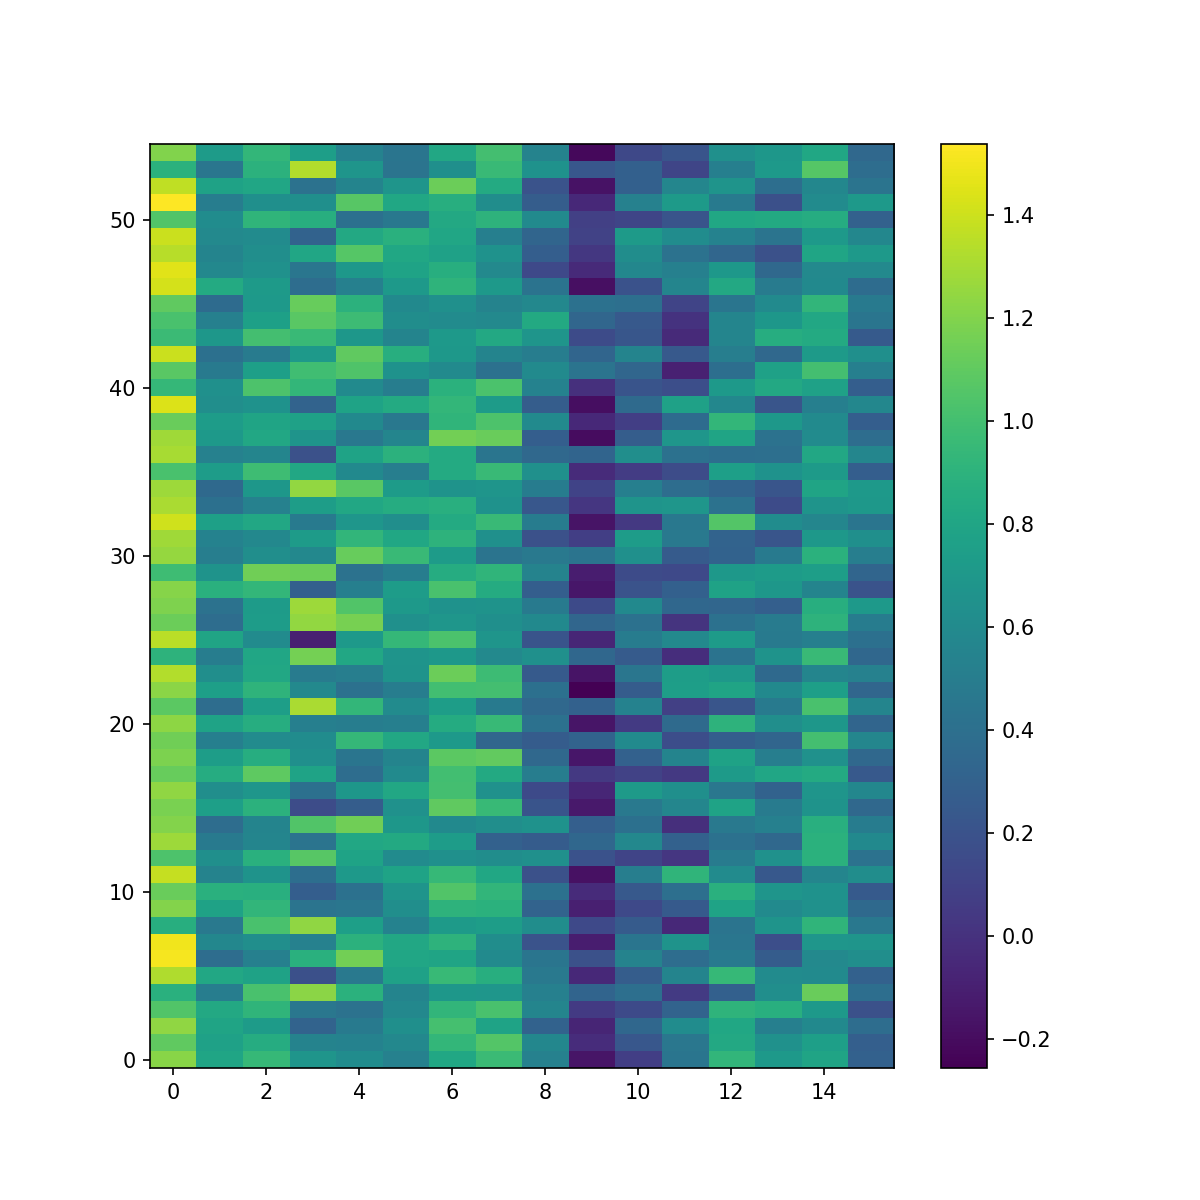

In [228]:
def Make_Graph(Wavelength):
    calVals = pd.read_csv('Calibration_Values.csv')
    PDA = .229 *.229 #cm^2
    if(str(Wavelength) == '850'):
        #make 850 graph
        NineVals = calVals[0:16]
        for k in range(56):
            for i in range(16):
                df.loc[k, 'PD' + str(i+1)] = ((df.loc[k,'PD' + str(i+1)])*(float(NineVals.loc[i,'Slope']))/PDA) + (float(NineVals.loc[i,'Intercept']))
        plt.close()
        df.drop('Time',axis = 1,inplace = True)
        df.drop('Position', axis = 1,inplace = True)
        #drop first row of garbage initializtion values
        df.drop(0,axis=0,inplace = True)
        l = np.array(df)
        #flip horizontaly nd verticly to get data in position that represents actual rig
        l = np.fliplr(l)
        #plot in a heat map
        plt.close('all')
        P_lot = plt.figure(figsize=(8,8))
        # plot in a color map 
        plt.imshow(l, cmap ="viridis", aspect='auto')
        # make a color bar
        plt.colorbar()
        #fip verticly to acuratly represent rig
        plt.gca().invert_yaxis()
    if(str(Wavelength) == '940'):
        #make 940 graph
        EightVals = calVals[16:32]
        for k in range(56):
            for i,j in zip(range(16),range(16,32)):
                df.loc[k, 'PD' + str(i+1)] = ((df.loc[k,'PD' + str(i+1)])*(float(EightVals.loc[j,'Slope']))/PDA) + (float(EightVals.loc[j,'Intercept']))
        G2 = df.drop('Time',axis = 1)
        G2 = df.drop('Position', axis = 1)
        #drop first row of garbage initializtion values
        G2 = df.drop(0,axis=0)
        l = np.array(G2)
        #flip horizontaly nd verticly to get data in position that represents actual rig
        l = np.fliplr(l)
        #plot in a heat map
        plt.close('all')
        P_lot = plt.figure(figsize=(8,8))
        # plot in a color map 
        plt.imshow(l, cmap ="viridis", aspect='auto')
        # make a color bar
        plt.colorbar()
        #fip verticly to acuratly represent rig
        plt.gca().invert_yaxis()
    if(str(Wavelength) == 'BLUE????'):
        #make BLUE graph
        print('')
Make_Graph(850)

# Below is calibrating the Photo Detectors
## this is done by collection data points at same intenisty for each wavelength with the photo detector then the Optical Power Meter
 We then find a line of best fit and use that line to calibrate that data too

In [161]:
#data
OPMdata940 = [31,21,11]
PHOTOdata940 = [.115,.074,.042]
OPMdata850 = [24.5,15,6]
PHOTOdata850 = [.091,.058,.028]

#creating data frame to hold data
data = {'OPMdata940':[31,21,11],'PHOTOdata940': [.115,.074,.042],'OPMdata850':[24.5,15,6],'PHOTOdata850': [.091,.058,.028]}
df = pd.DataFrame(data)
print(df)

   OPMdata940  PHOTOdata940  OPMdata850  PHOTOdata850
0          31         0.115        24.5         0.091
1          21         0.074        15.0         0.058
2          11         0.042         6.0         0.028


<AxesSubplot:xlabel='OPMdata850'>

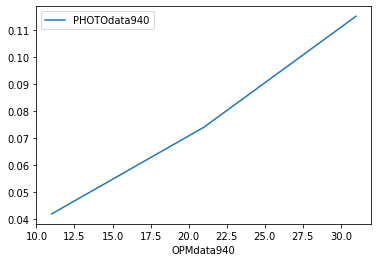

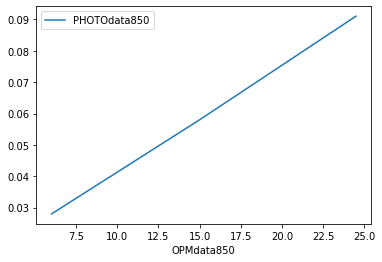

In [163]:
#plot both 'Sanity Check'
df.plot(x="OPMdata940", y="PHOTOdata940")
df.plot(x="OPMdata850", y="PHOTOdata850")

In [187]:
array = [[31,21,11],[.115,.074,.042],[24.5,15,6],[.091,.058,.028]]

In [21]:
yO_940 = np.array([31,21,11]) #x values for 940 pulled out in numpy array
xP_940 = np.array([.115,.074,.042]) #y values for 940 pulled out in numpy array

yO_850 = np.array([24.5,15,6]) #x values for 850 pulled out in numpy array
xP_850 = np.array([.091,.058,.028]) #y values for 850 pulled out in numpy array

In [22]:
for i in range(3):
    xP_940[i] = xP_940[i]/PDA
    yO_940[i] = yO_940[i]/OPMA
    
    xP_850[i] = xP_850[i]/PDA
    yO_850[i] = yO_850[i]/OPMA

In [23]:
m9, b9 = np.polyfit(xP_940, yO_940, 1) #find slope m9 and intercept b9 --940
m8, b8 = np.polyfit(xP_850, yO_850, 1) #find slope m8 and intercept b8 --850

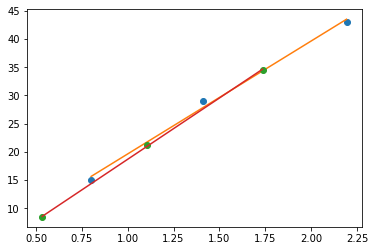

In [24]:
plt.plot(xP_940, yO_940, 'o')
plt.plot(xP_940, m9*xP_940 + b9)

plt.plot(xP_850, yO_850, 'o')
plt.plot(xP_850, m8*xP_850 + b8)


In [8]:
#optical power meter area
OPMA = .7088 #cm^2

#Photo detector area
PDA = .229 *.229 #cm^2

In [14]:
#optical power meter area
OPMA = .7088 #cm^2

#Photo detector area
PDA = .229 *.229 #cm^2

def Callibrate():
    #get user input as calibration test is run by hand
    detNum = input('Detector # :')
    Wav = input('Wavelength: ')
    OPM1 = input('OPM Val: ')
    PH1 = input('PHOTO Val: ')
    OPM2 = input('OPM Val: ')
    PH2 = input('PHOTO Val: ')
    OPM3 = input('OPM Val: ')
    PH3 = input('PHOTO Val: ')
    
    #optical power meter area
    OPMA = .7088 #cm^2

    #Photo detector area
    PDA = .229 *.229 #cm^2
    
    #get my x and y arrays of photo detector values and OPM values
    x = np.array([float(PH1),float(PH2),float(PH3)])
    y = np.array([float(OPM1),float(OPM2),float(OPM3)])
    
    #devide them by the area of each photo collection device to get Watts/cm^2
    for i in range(3):
        x[i] = x[i]/PDA
        y[i] = y[i]/OPMA
    
    slope, intercept = np.polyfit(x, y, 1) #find slope and intercept
    plt.plot(x,y,'o')
    plt.plot(x,slope*x+intercept)
    name = 'Calibration_Values'
    #change path to your own path if operated on computer other than Aaron Schurman's
    dirLoc = "C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\" + name + ".csv" 
    header = ['photoNum', 'Wav', 'Slope', 'Intercept']
    #creats a new csv file at the dirLoc path
    try:
        with open(dirLoc, 'w') as path:
            #defines the csv writer to 
            writer = csv.writer(path)
            #writes the header for the file
            writer.writerow(header)
            writer.writerow([detNum,Wav,slope,intercept])
    except Exception as e:
        print(e)
        print('Failed to create file and write to it. Most likely file is still open, close it dummy')
    
    

In [16]:
Callibrate()

Detector # :1
Wavelength: 850
OPM Val: 25.5


KeyboardInterrupt: Interrupted by user

PHOTO Val:  zc


In [41]:
calVals = pd.read_csv('Calibration_Values.csv')

In [42]:
calVals

,photoNum,Wav,Slope,Intercept
0,1,850,22.137618,-3.483244
1,2,850,20.972498,-2.791611
2,3,850,20.130979,-3.032215
3,4,850,22.233158,-3.140368
4,5,850,26.218601,-4.107788
5,6,850,21.221454,-3.351615
6,7,850,20.643406,-3.247265
7,8,850,19.764770,-3.196267
8,9,850,25.274244,-3.718857
9,10,850,19.251703,-2.562850


In [15]:
rob = Motor('COM6')
rob.home()


Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1


In [20]:
rob.move_pos(910-26)

G0 X884 Y884



In [42]:
calVals = pd.read_csv('Calibration_Values.csv')
EightVals = calVals[0:16]
PDA = .229 *.229 #cm^2
OPMA = .7088 #cm^2
daq = DAQ()
num = input('Input Detector Number for test')
place = 26 * int(input('input value from 0-55'))
data = [0]
done  = False
df = pd.DataFrame(data, columns=['Volts'])
daq.creat_single_volt_RSE_task("cDAQ1Mod1/ai" + num)
rob = Motor('COM6')
rob.home()
rob.move_pos(place)
ti.sleep(20)
daq.start()
df = daq.collect_data(df)
ti.sleep(3)
daq.stop()
#rob.move_pos(place - 31.75)
d = input('Type T if done : ')
if d == 'T':
    done = True
if done == True:
    rob.move_pos(0)
    ti.sleep(5)
    rob.close()
mean = df.mean()
final_num = ((mean/PDA) * EightVals.loc[int(num), 'Slope']) + EightVals.loc[int(num), 'Intercept']
OPM_num  = input('Optical Power Meter Num : ')
print('PD value in mw / cm^2 : ')
print(final_num)
print('OPM value in mw / cm^2 : ')
print(float(OPM_num)/float(OPMA))

Input Detector Number for test8
input value from 0-5535

Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1
G0 X910 Y910



C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<16>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


Type T if done : N
Optical Power Meter Num : 9.6
PD value in mw / cm^2 : 
Volts    14.753303
dtype: float64
OPM value in mw / cm^2 : 
13.544018058690744


Volts    0.023914
dtype: float64


In [47]:
daq = DAQ()
daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
rob = Motor('COM6')
rob.home()
ray = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
for i in range(10):
    #set up data to make Pandas data frame with
    data = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
    read = dict() 
    #creat data frame to store data
    ray[i] = pd.DataFrame(data, columns=['PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16'])
    #start up daq aquisition can keep running this till very end of test. Will record data when necesarry
    x=0
    broke = 1
    #this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
    length_o_rig = 55
    while (x != length_o_rig) & (broke == 1):
        #move 26 mm after ever loop
        pos = 26*(x+1)
        rob.move_pos(pos)
        #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
        #when you see correct position you know it has stopped moving 
        # the key is to read_until and flush_input both these somehow make it respond back super duper quick
        # this gives mm level precision to location
        tf = 1
        while tf==1 & broke == 1:
            rob.flushInput()
            #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
            ti.sleep(.1)
            rob.write('?')
            temp = ''
            #this collects the response back
            temp = rob.read_until(temp)
            # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
            split1 = temp.split(',')[1]
            pos_check = split1.split('.')[0]
            print(pos_check)
            #this number is the position the software understands the motor to be at
            start = 1495
            #I check if the position I sent it to is where it is currently 
            #this is where data collection happens
            if ((int(pos_check)-1) <= int((-start + pos))) & ((int(pos_check)+1) >= int((-start + pos))):
                #collect current time and put it in data frame
                ti.sleep(.1)
                daq.start()
                #function in API built above see for code mechanism
                read = daq.collect_all_data(read)
                ti.sleep(.1)
                daq.stop()
                read['Time'] = dt.now()
                read['Position'] = pos
                ray[i] = ray[i].append(read, ignore_index=True)
                tf=0
        x+=1
    #step it back to home position 
    ray[i] = np.array(ray[i])
    rob.move_pos(500)
    ti.sleep(3)
    rob.move_pos(0)
    #cannot close down communication untill device is done moving
    ti.sleep(10)
    #close devices
rob.close()
d = np.stack([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])
meanArray = d.mean(axis=2)
stdArray = d.std(axis = 2)



Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1


NameError: name 'df1' is not defined

In [160]:
daq = DAQ()
daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
rob = Motor('COM6')
rob.home()   
ray = []    
for i in range(10):
    #set up data to make Pandas data frame with
    data = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
    read = dict()
    #creat data frame to store data
    df = pd.DataFrame(data, columns=['PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16'])
    #start up daq aquisition can keep running this till very end of test. Will record data when necesarry
    x=0
    broke = 1
    #this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
    length_o_rig = 55
    while (x != length_o_rig) & (broke == 1):
        #move 26 mm after ever loop
        pos = 26*(x+1)
        rob.move_pos(pos)
        #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
        #when you see correct position you know it has stopped moving 
        # the key is to read_until and flush_input both these somehow make it respond back super duper quick
        # this gives mm level precision to location
        tf = 1
        while tf==1 & broke == 1:
            rob.flushInput()
            #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
            ti.sleep(.1)
            rob.write('?')
            temp = ''
            #this collects the response back
            temp = rob.read_until(temp)
            # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
            split1 = temp.split(',')[1]
            pos_check = split1.split('.')[0]
            print(pos_check)
            #this number is the position the software understands the motor to be at
            start = 1495
            #I check if the position I sent it to is where it is currently 
            #this is where data collection happens
            if ((int(pos_check)-1) <= int((-start + pos))) & ((int(pos_check)+1) >= int((-start + pos))):
                #collect current time and put it in data frame
                ti.sleep(.1)
                daq.start()
                #function in API built above see for code mechanism
                read = daq.collect_all_data(read)
                ti.sleep(.1)
                daq.stop()
                #read['Time'] = dt.now()
                #read['Position'] = pos
                df = df.append(read, ignore_index=True)
                tf=0
        x+=1
    df.drop(0,axis=0,inplace = True)
    ray.append(df)
    #step it back to home position 
    rob.move_pos(500)
    ti.sleep(3)
    rob.move_pos(0)
    #cannot close down communication untill device is done moving
    ti.sleep(10)
#close devices
rob.close()



Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1
G0 X26 Y26


-1494

-1492

-1485

-1477

-1470
G0 X52 Y52

ok
ok

-1467

-1461

-1453

-1446

-1443
G0 X78 Y78

ok
ok

-1441

-1434

-1426

-1419

-1416
G0 X104 Y104

ok
ok

-1415

-1409

-1399

-1392
G0 X130 Y130

ok
ok

-1389

-1382

-1373

-1366
G0 X156 Y156

ok
ok

-1363

-1356

-1346

-1340
G0 X182 Y182

ok
ok

-1337

-1330

-1320

-1314
G0 X208 Y208

ok
ok

-1311

-1304

-1294

ok

-1289

-1287
G0 X234 Y234

ok
ok

-1285

-1278

-1268

-1262
G0 X260 Y260

ok
ok

-1259

-1252

-1243

-1236
G0 X286 Y286

ok
ok

-1233
k
ok

-1227

-1218

-1211

-1208
G0 X312 Y312

ok
ok

-1207

-1200

-1190

-1184
G0 X338 Y338

ok
ok

-1181

-1174
ok

-1166

-1159

-1157
G0 X364 Y364

ok
ok

-1155

-1149

-1140

-1133

-1130
G0 X390 Y390

ok
ok

-1129

-1122

-1114

-1107

-1105
G0 X416 Y416

ok
ok

-1103

-1097

-1088

-1081

-1079
G0 X442 Y44


-187

-177

-170
G0 X1352 Y1352

ok
ok

-167

-160

-151

-144
G0 X1378 Y1378

ok
ok

-141

-134

-126

-119

-116
G0 X1404 Y1404

ok
ok

-115

-108

-98

-92
G0 X1430 Y1430

ok
ok

-89

-82

-72

-67

-65
G0 X500 Y500

G0 X0 Y0

G0 X26 Y26

ok
ok

-1493

-1487

-1477

-1471

-1469
G0 X52 Y52

ok
ok

-1467

-1461

-1451

-1445

-1442
G0 X78 Y78

ok
ok

-1441

-1434

-1424

-1418
G0 X104 Y104

ok
ok

-1415

-1408

-1399

-1393

-1391
G0 X130 Y130

ok
ok

-1389

-1382

-1372

-1366
G0 X156 Y156

ok
ok

-1363

-1356

-1346

-1340
G0 X182 Y182

ok
ok

-1337

-1330

-1321

-1314
G0 X208 Y208

ok
ok

-1311

-1304

-1294

-1288
G0 X234 Y234

ok
ok

-1285

-1278

-1269

-1262
G0 X260 Y260

ok
ok

-1259

-1253

-1243

-1237

-1235
G0 X286 Y286

ok
ok

-1233

-1226

-1216

-1210
G0 X312 Y312

ok
ok

-1207

-1200

-1190

-1184
G0 X338 Y338

ok
ok

-1181

-1174

-1164

-1158
G0 X364 Y364

ok
ok

-1155

-1149

-1140

-1133

-1130
G0 X390 Y390

ok
ok

-1129

-1123

-1113

ok

-1107

-1105
G0 X416 Y


-249

-247
G0 X1274 Y1274

ok
ok

-245

-240

-230

-223

-220
G0 X1300 Y1300

ok
ok

-219

-213

-204

-197

-195
G0 X1326 Y1326

ok
ok

-193

-186

-178

-171

-169
G0 X1352 Y1352

ok
ok

-167

-161

-152

-145

-142
G0 X1378 Y1378

ok
ok

-141

-134

-124

-118
G0 X1404 Y1404

ok
ok

-115

-108

-98

-92
G0 X1430 Y1430

ok
ok

-89

-82

-72

-66
G0 X500 Y500

G0 X0 Y0

G0 X26 Y26

ok
ok

-1493

-1487

-1477

-1471

-1469
G0 X52 Y52

ok
ok

-1467

-1460

-1450

-1444
G0 X78 Y78

ok
ok

-1441


-1435

-1427

-1420

-1417
G0 X104 Y104

ok
ok

-1415

-1408

-1400

-1393

-1391
G0 X130 Y130

ok
ok

-1389

-1382

-1372

-1366
G0 X156 Y156

ok
ok

-1363

-1357

-1348

-1341

-1338
G0 X182 Y182

ok
ok

-1337

-1331

-1322

-1315

-1313
G0 X208 Y208

ok
ok

-1311

-1304

-1294


-1289

-1287
G0 X234 Y234

ok
ok

-1285

-1278

-1268

-1263

-1260
G0 X260 Y260

ok
ok

-1259

-1253

-1244

-1237

-1235
G0 X286 Y286

ok
ok

-1233

-1226

-1218

-1211

-1208
G0 X312 Y312

ok
ok

-1207

-1200

-1

G0 X1170 Y1170

ok
ok

-349

-344

-334

-327

-325
G0 X1196 Y1196

ok
ok

-323

-316

-307

-301

-299
G0 X1222 Y1222

ok
ok

-297

-290

-281

-275

-273
G0 X1248 Y1248

ok
ok

-271

-264

-255

-249

-247
G0 X1274 Y1274

ok
ok

-245

-238

-228

-222
G0 X1300 Y1300

ok
ok

-219

-212

-202

-196
G0 X1326 Y1326

ok
ok

-193

-187

-178

-171

-169
G0 X1352 Y1352

ok
ok

-167

-161

-152

-145

-143
G0 X1378 Y1378

ok
ok

-141

-135

-127

-119

-117
G0 X1404 Y1404

ok
ok

-115

-108

-98
k
ok

-92
G0 X1430 Y1430

ok
ok

-89

-82

-72
ok

-67

-65
G0 X500 Y500

G0 X0 Y0

G0 X26 Y26

ok
ok

-1493

-1486

-1477

ok

-1471

-1469
G0 X52 Y52

ok
ok

-1467

-1460

-1451

-1445

-1442
G0 X78 Y78

ok
ok

-1441

-1435

-1427

-1419

-1417
G0 X104 Y104

ok
ok

-1415

-1408

-1398

-1392
G0 X130 Y130

ok
ok

-1389

-1383

-1373


-1367

-1364
G0 X156 Y156

ok
ok

-1363

-1356

-1348

-1341

-1339
G0 X182 Y182

ok
ok

-1337

-1331

-1323

-1315

-1313
G0 X208 Y208

ok
ok

-1311

-1304

-1296

-1

In [220]:
ray_copy = []
for i in range(10):
    ray_copy.append(np.array(ray[i]))
    #ray_copy[i] = np.fliplr(ray_copy[i])

In [221]:
stack = np.stack(ray_copy)

In [222]:
meanArray = stack.mean(axis = 0)

In [223]:
stdArray = stack.std(axis = 0)

In [224]:
stdDiv = stdArray/meanArray

<IPython.core.display.Javascript object>


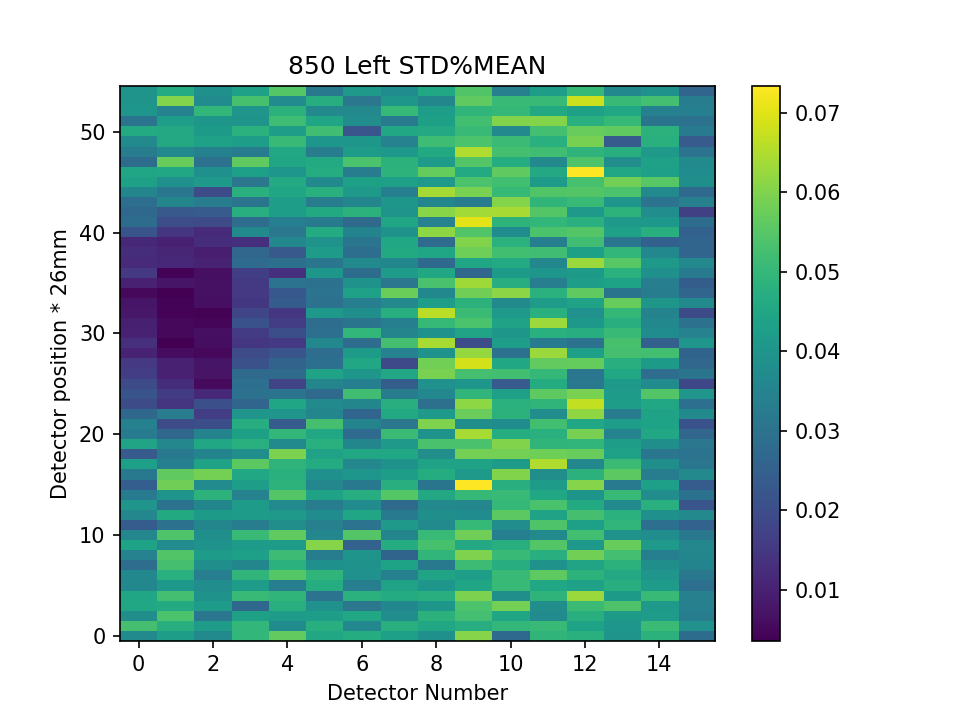

In [225]:
plt.figure()
plt.imshow(stdDiv, cmap ="viridis", aspect='auto')
# make a color bar
plt.colorbar()
plt.xlabel('Detector Number')
plt.ylabel('Detector position * 26mm')
plt.gca().invert_yaxis()
plt.title('850 Left STD%MEAN')
# make a color ba
plt.savefig('C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Calibration_Plots\\850_Left_STD%MEAN.png')

<IPython.core.display.Javascript object>


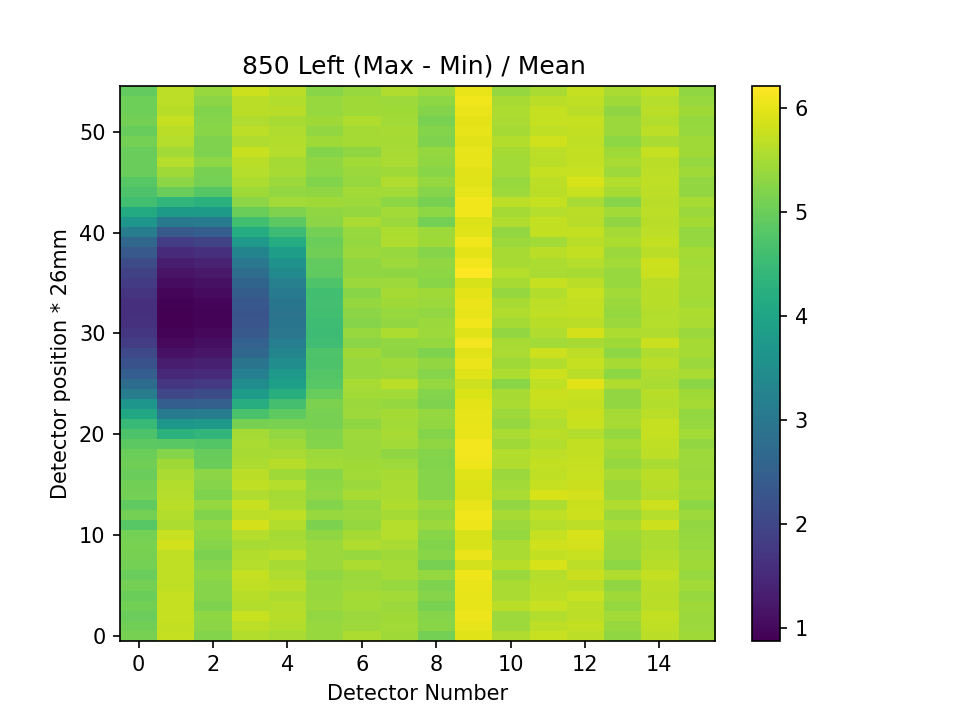

In [226]:
maxi = stack.max()
mini = stack.min()
new_val =  (maxi-mini)/meanArray
plt.figure()
plt.imshow(new_val, cmap ="viridis", aspect='auto')
# make a color bar
plt.colorbar()
plt.xlabel('Detector Number')
plt.ylabel('Detector position * 26mm')
plt.gca().invert_yaxis()
plt.title('850 Left (Max - Min) / Mean ')
plt.savefig('C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Calibration_Plots\\850_Left_MAX-MIN%MEAN.png')

In [168]:
for i in range(10):    
    osDir = 'C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Raw_Calibration_Data\\Right_light\\run' + str(i)+ '.csv'
    np.savetxt(osDir, ray_copy[i], delimiter=",")

In [219]:
from numpy import genfromtxt
ray = []
for i in range(10):
    osDir = 'C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Raw_Calibration_Data\\Left_light\\run' + str(i)+ '.csv'
    ray.append(genfromtxt(osDir, delimiter=','))